In [1]:
import sys
import os
from matplotlib import pyplot as plt

sys.path.append("..")
os.chdir("/home/sean/HAI/main_server/hai")
import hai

Input password for image encryption.
········


In [2]:
import database as db

In [3]:
import time
current_time = time.time()-1200
print(current_time)

1505045739.9041457


In [38]:
t = 1505039422
query = {"user_name": "sean", "cam_id": "0", "summary":{"$exists": True}, "time": {"$gt": t}}
n = db.mongo.images.find(query).sort([("time",-1)])
image_data = list(n)

query = {"user_name": "sean", "time": {"$gt": t}}
n = db.mongo.hue.find(query).sort([("time",-1)])
hue_data = list(n)

print(len(image_data), len(hue_data))

2105 772


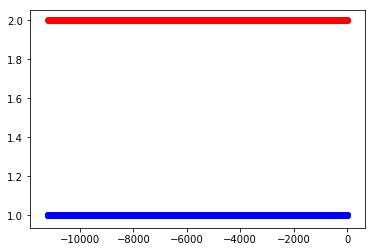

In [39]:
import numpy as np
import time
current_time = time.time()
image_times = [img["time"]-current_time for img in image_data]
hue_times = [d["time"]-current_time for d in hue_data]
plt.scatter(image_times, np.ones(len(image_times)), color="blue")
plt.scatter(hue_times, np.ones(len(hue_times))*2, color="red")
plt.show()

In [40]:
hue_data[0]

{'_id': ObjectId('59b53ff11d41c87937e31ecb'),
 'lights': '[{"name": "Hue color lamp 1", "manufacturername": "Philips", "modelid": "LCT007", "id": "1", "uniqueid": "00:17:88:01:02:06:bc:4f-0b", "type": "Extended color light", "state": {"xy": [0, 0], "hue": 0, "reachable": false, "colormode": "hs", "effect": "none", "sat": 0, "on": true, "bri": 0, "alert": "none", "ct": 0}, "swversion": ""}, {"name": "Hue color lamp 2", "manufacturername": "Philips", "modelid": "LCT007", "id": "2", "uniqueid": "00:17:88:01:02:04:d6:7c-0b", "type": "Extended color light", "state": {"xy": [0.4449, 0.4066], "hue": 15327, "reachable": true, "colormode": "ct", "effect": "none", "sat": 121, "on": false, "bri": 68, "alert": "none", "ct": 346}, "swversion": "5.38.1.14919"}, {"name": "Hue color lamp 3", "manufacturername": "Philips", "modelid": "LCT007", "id": "3", "uniqueid": "00:17:88:01:02:06:bb:4c-0b", "type": "Extended color light", "state": {"xy": [0.4449, 0.4066], "hue": 15324, "reachable": true, "colormod

In [41]:
def get_objects(data):
    look_all, touch_all = [], []
    for n in data:
        look_objects = []
        touch_objects = []
        for obj in n["summary"]:
            if obj["label"] == "person" and "touching" in obj:
                touch_objects.extend(obj["touching"])
                look_objects.append(obj["looking"])
        look_all.extend(look_objects)
        touch_all.extend(touch_objects)
    return touch_all, look_all

touch_list, look_list = get_objects(image_data)
touch_classes = list(set(touch_list))
look_classes = list(set(look_list))
look_classes.remove("None")

In [42]:
print(touch_classes, look_classes)
touch_classes.index("person")

['laptop', 'toothbrush', 'suitcase', 'cup', 'tie', 'person', 'book', 'fork', 'tennis racket', 'keyboard', 'couch', 'backpack', 'chair', 'cell phone', 'remote'] ['laptop', 'tie', 'person', 'knife', 'book', 'couch', 'backpack', 'cell phone', 'remote']


5

In [47]:
def data2vec(data):
    person_exists = 0
    touch_vec = np.zeros(len(touch_classes))
    look_vec = np.zeros(len(look_classes))
    #brightness = data["brightness"]

    for obj in data["summary"]:
        if obj["label"] == "person":
            person_exists = 1
            
            if "touching" in obj:
                for t_obj in obj["touching"]:
                    touch_vec[touch_classes.index(t_obj)] = 1
                if obj["looking"] and obj["looking"] != "None":
                    look_vec[look_classes.index(obj["looking"])] = 1
        
    return np.concatenate([[person_exists], touch_vec, look_vec])

In [48]:

dataX = [] # summaries

dataX = [data2vec(data) for data in image_data]

In [49]:
dataX = np.array(dataX)
print(dataX.shape)

(2105, 25)


['laptop', 'toothbrush', 'suitcase', 'cup', 'tie', 'person', 'book', 'fork', 'tennis racket', 'keyboard', 'couch', 'backpack', 'chair', 'cell phone', 'remote'] ['laptop', 'tie', 'person', 'knife', 'book', 'couch', 'backpack', 'cell phone', 'remote']
(2105, 25)


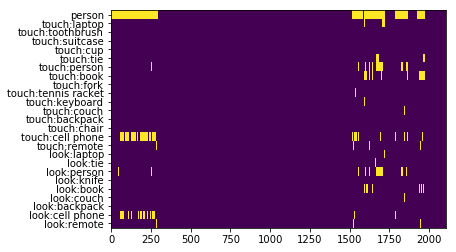

In [50]:
%matplotlib inline
print(touch_classes, look_classes)

ylabels = ["person"] + ["touch:" + t for t in touch_classes] + ["look:" + t for t in look_classes]
plt.yticks(np.arange(len(ylabels)), ylabels)
plt.imshow(dataX.T, aspect="auto")
print(dataX.shape)

In [ ]:
from scipy.misc import imread
"""
for i in range(0, len(image_data), 10):
    img = imread("images/raw_images/" + image_data[i]["filename"])
    plt.title(str(i))
    plt.imshow(img, aspect="auto")
    plt.show()
"""

'\nfor i in range(0, len(image_data), 10):\n    img = imread("images/raw_images/" + image_data[i]["filename"])\n    plt.title(str(i))\n    plt.imshow(img, aspect="auto")\n    plt.show()\n'

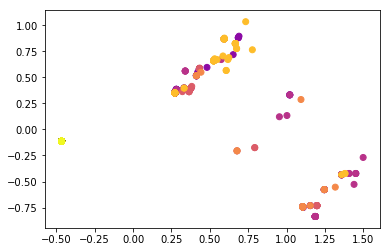

missing file ./pose_data/46b6010c-a4ab-4dfc-aa1a-af2667fb4240_keypoints.json
missing file ./pose_data/302b289d-f1a7-4a23-a59c-6de742e9fe3c_keypoints.json
missing file ./pose_data/931d310d-6625-4a73-8a8f-6fd355c73b37_keypoints.json
missing file ./pose_data/1b9b689f-8c35-4ba8-84e1-89baa236b04f_keypoints.json
missing file ./pose_data/8cfd0af7-b25c-4d03-92cb-499541177ec4_keypoints.json


In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
dataX_r = pca.fit(dataX).transform(dataX)

colors = [i / 8 for i in range(8) for _ in range(100)]
#colors = [(i / len(dataX), 0, 0) for i in range(len(dataX))]
plt.scatter(dataX_r[:,0], dataX_r[:,1], c=colors, cmap=plt.get_cmap("plasma"))

In [78]:
import json

def get_hue_data(row):
    vec = []
    for light in row:
        state = light["state"]
        if state["reachable"]:
            vec.append([int(state["on"]), state["hue"] / 65535.0, state["sat"] / 255.0, state["bri"] / 255.0])
        else:
            vec.append(None)
    return vec
        
hue_mat = [get_hue_data(json.loads(hue_data[i]["lights"])) for i in range(len(hue_data))]

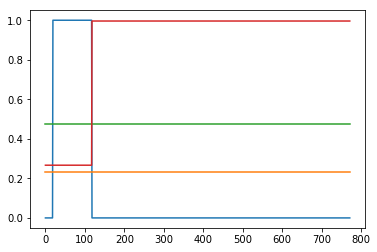

missing file ./pose_data/fb38e9ea-5869-41e5-bfb5-7b437faeb837_keypoints.json
missing file ./pose_data/20eb5da5-4e33-4c87-b861-1fbe955941fb_keypoints.json
missing file ./pose_data/8d657e51-7f65-4788-8638-1790e8b45ec4_keypoints.json
missing file ./pose_data/62adddd9-0a14-4e19-9518-98f7ab00a94a_keypoints.json
missing file ./pose_data/63a7ac38-977d-438a-8b54-c77cc529b4b7_keypoints.json
missing file ./pose_data/0bdbd3dd-5506-45bc-9339-43785ed25934_keypoints.json
missing file ./pose_data/e30b5c27-05c5-491c-8c3e-dd54b317ff7e_keypoints.json
missing file ./pose_data/915e7956-768d-4e62-ac83-5e5cfbd78856_keypoints.json
missing file ./pose_data/838f62a0-80bf-4c8c-a0db-392e5ba743fc_keypoints.json
missing file ./pose_data/dd826dd6-1ffb-4044-bc8d-3f64004b26c1_keypoints.json
missing file ./pose_data/240a394d-f8f4-43c1-9623-fdfc548aeeb5_keypoints.json
missing file ./pose_data/8f1d7075-46ef-4537-ad5b-ba6e7cbc68b4_keypoints.json
missing file ./pose_data/cedb5b8e-8c2d-4fb0-8dc8-68b3baaa909b_keypoints.json

In [81]:
light_hist = [row[1] for row in hue_mat]
plt.plot([hsb[0] for hsb in light_hist])
plt.plot([ohsb[1] for ohsb in light_hist])
plt.plot([ohsb[2] for ohsb in light_hist])
plt.plot([ohsb[3] for ohsb in light_hist])

In [ ]:
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier

dataX = preprocessing.scale(dataX)
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf.fit(dataX, dataY)
score = clf.score(dataX, dataY)
print("knn:", score)

from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(dataX, dataY)
score = logreg.score(dataX, dataY)
print("logreg:", score)

clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini.fit(dataX, dataY)
score = clf_gini.score(dataX, dataY)
print("tree:", score)
